In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))
    
from utils.classification import load_behaviors, load_data
from utils.meta import *
import matplotlib
import warnings
import seaborn as sns
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

### load predicted behaviors

In [2]:
poses = load_data('../processed_dataset/raw_data.pkl')

## Group-Condition - Distance Traveled Stat + Heatmap

In [36]:
import csv
import numpy as np

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

project = 'acc_lupe-morphine-efficacy'
selected_sex = 'Female'
selected_group = 'Group5'
selected_condition = 'Condition3'

# Conversion factor from pixels to units
pixels_to_units = 0.0330828  # meters = 0.000330708, cm = 0.0330828
unit = 'cm'

# Assuming poses is a dictionary containing pose data for different groups and conditions
# Example structure: poses[group][condition][file][frame][bodypart_idx]
poses_selected = poses[selected_sex][selected_group][selected_condition]

# Initialize a list to store distances traveled for each file
distances_traveled = []

# Initialize cumulative distance traveled
cumulative_distance_traveled = 0.0

for file_key in poses_selected:
    pose_data = poses_selected[file_key]
    total_distance_pixels = 0.0
    for frame in range(1, len(pose_data)):
        # Calculate Euclidean distance between consecutive frames in pixels
        distance_pixels = np.linalg.norm(pose_data[frame][bodypart_idx:bodypart_idx+2] - pose_data[frame-1][bodypart_idx:bodypart_idx+2])
        total_distance_pixels += distance_pixels
    # Convert total distance from pixels to units
    total_distance = total_distance_pixels * pixels_to_units
    # Append to list and update cumulative distance traveled
    distances_traveled.append(total_distance)
    cumulative_distance_traveled += total_distance

# Convert list to numpy array for easier computation
distances_traveled = np.array(distances_traveled)

# Calculate statistics
average_distance = np.mean(distances_traveled)
standard_deviation = np.std(distances_traveled)
sem = standard_deviation / np.sqrt(len(distances_traveled))

# Print results
print(f"Average distance traveled for sex '{selected_sex}' and group '{selected_group}' and condition '{selected_condition}': {average_distance:.2f} {unit}")
print(f"Standard deviation: {standard_deviation:.2f} {unit}")
print(f"Standard error of the mean (SEM): {sem:.2f} {unit}")
print(f"Cumulative distance traveled: {cumulative_distance_traveled:.2f} {unit}")

# Save statistics to CSV
output_filename = f'../processed_dataset/behavior_distance-traveled/behavior_distance_stats-{unit}_{selected_sex}_{selected_group}_{selected_condition}_{project}.csv'
with open(output_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Statistic', 'Value'])
    writer.writerow(['Average distance traveled', f'{average_distance:.2f} {unit}'])
    writer.writerow(['Standard deviation', f'{standard_deviation:.2f} {unit}'])
    writer.writerow(['Standard error of the mean (SEM)', f'{sem:.2f} {unit}'])
    writer.writerow(['Cumulative distance traveled', f'{cumulative_distance_traveled:.2f} {unit}'])

Average distance traveled for sex 'Female' and group 'Group5' and condition 'Condition3': 21145.38 meters
Standard deviation: 3360.35 meters
Standard error of the mean (SEM): 1062.63 meters
Cumulative distance traveled: 211453.78 meters


## CUMULATIVE Distance Traveled CSV! + Figure!

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_48186/3980037819.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


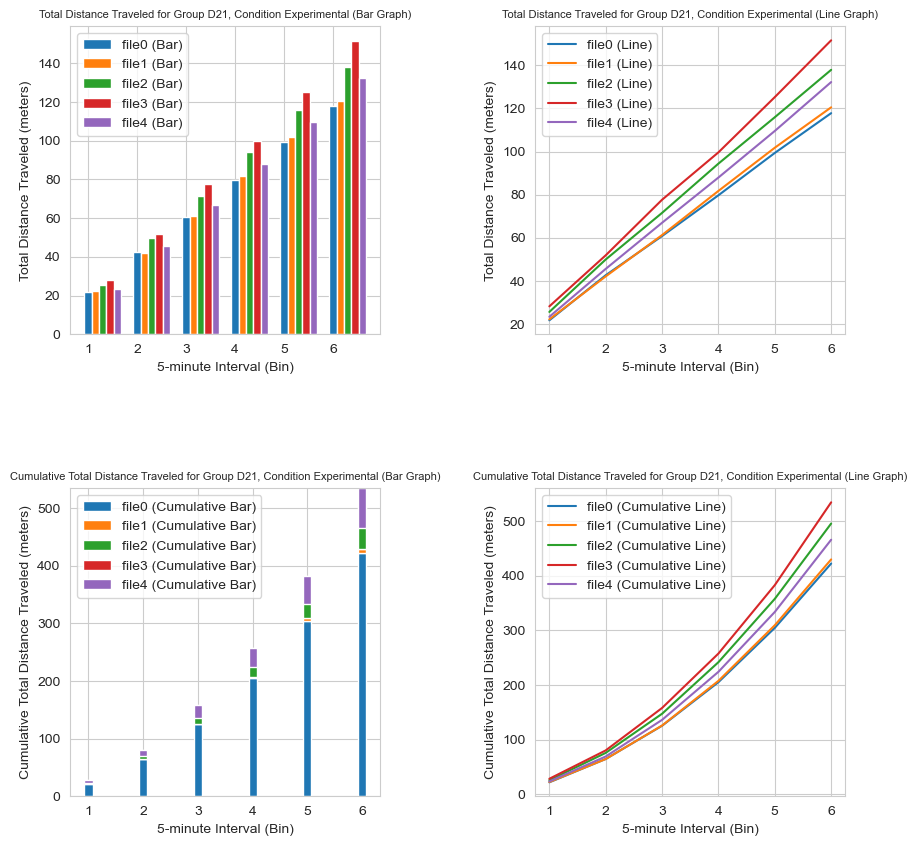

In [22]:
import csv
import numpy as np
import matplotlib.pyplot as plt

project = 'raquel'
selected_group = 'D21'
selected_condition = 'Experimental'

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

# Conversion factor from pixels to units
pixels_to_units = 0.000330708  # meters = 0.000330708, cm = 0.0330828
unit = 'meters'

# Number of frames representing a XX-minute interval
    # 1-minute bin = 3600
    # 2-minute bin = 7200
    # 3-minute bin = 10800
    # 5-minute bin = 18000
bin_interval = '5-minute'
frames_per_bin = 18000

# Assuming poses is a dictionary containing pose data for different groups and conditions
# Example structure: poses[group][condition][file][frame][bodypart_idx]
poses_selected = poses[selected_group][selected_condition]

##### CSV SAVE!!!
output_filename = f'../processed_dataset/behavior_distance-traveled/behavior_distance-cumulative-{unit}_{selected_group}_{selected_condition}_{project}.csv'

# Collect the file keys for all files
file_keys = list(poses_selected.keys())

with open(output_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ['Bin']
    header.extend(file_keys)  # Add file keys as column headers
    writer.writerow(header)

    for frame in range(1, len(poses_selected[file_keys[0]])):
        if frame % frames_per_bin == 0:
            bin_number = frame // frames_per_bin
            row_data = [bin_number]

            for file_key in file_keys:
                pose_data = poses_selected[file_key]
                total_distance_units = 0.0
                for f in range(1, frame+1):
                    distance_pixels = np.linalg.norm(pose_data[f][bodypart_idx:bodypart_idx+2] - pose_data[f-1][bodypart_idx:bodypart_idx+2])
                    total_distance_units += distance_pixels * pixels_to_units

                row_data.append(total_distance_units)

            writer.writerow(row_data)

# Initialize a dictionary to store the total distance traveled for each file
total_distances = {file_key: [] for file_key in file_keys}

with open(output_filename, mode='r', newline='') as file:
    reader = csv.DictReader(file)
    for row in reader:
        bin_number = int(row['Bin'])
        for file_key in file_keys:
            total_distance_units = float(row[file_key])
            total_distances[file_key].append(total_distance_units)

# Create cumulative total distance traveled
cumulative_distances = {}
for file_key in file_keys:
    cumulative_distances[file_key] = np.cumsum(total_distances[file_key])

# Create a new figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
bar_width = 0.15
bin_numbers = range(1, len(total_distances[file_keys[0]]) + 1)

# Create the bar graph
for file_key in file_keys:
    axs[0, 0].bar([b + bar_width * file_keys.index(file_key) for b in bin_numbers], total_distances[file_key], width=bar_width, label=f'{file_key} (Bar)')

# CHANGE AXIS LABELS FOR UNIT
axs[0, 0].set_xlabel(f'{bin_interval} Interval (Bin)')
axs[0, 0].set_ylabel(f'Total Distance Traveled ({unit})')
axs[0, 0].set_title(f'Total Distance Traveled for Group {selected_group}, Condition {selected_condition} (Bar Graph)', fontsize=8) 
axs[0, 0].set_xticks(bin_numbers)
axs[0, 0].legend()

# Create the line graph
for file_key in file_keys:
    axs[0, 1].plot(bin_numbers, total_distances[file_key], label=f'{file_key} (Line)')

# CHANGE AXIS LABELS FOR UNIT
axs[0, 1].set_xlabel(f'{bin_interval} Interval (Bin)')
axs[0, 1].set_ylabel(f'Total Distance Traveled ({unit})')
axs[0, 1].set_title(f'Total Distance Traveled for Group {selected_group}, Condition {selected_condition} (Line Graph)', fontsize=8) 
axs[0, 1].set_xticks(bin_numbers)
axs[0, 1].legend()

# Create bar graph for cumulative total distance traveled
axs[1, 0].bar(bin_numbers, cumulative_distances[file_keys[0]], label=f'{file_keys[0]} (Cumulative Bar)', width=bar_width)
for i, file_key in enumerate(file_keys[1:]):
    axs[1, 0].bar(bin_numbers, cumulative_distances[file_key] - cumulative_distances[file_keys[i]], 
                  bottom=cumulative_distances[file_keys[i]], label=f'{file_key} (Cumulative Bar)', width=bar_width)

# CHANGE AXIS LABELS FOR UNIT
axs[1, 0].set_xlabel(f'{bin_interval} Interval (Bin)')
axs[1, 0].set_ylabel(f'Cumulative Total Distance Traveled ({unit})')
axs[1, 0].set_title(f'Cumulative Total Distance Traveled for Group {selected_group}, Condition {selected_condition} (Bar Graph)', fontsize=8)  # Adjust title font size
axs[1, 0].set_xticks(bin_numbers)
axs[1, 0].legend()

# Create line graph for cumulative total distance traveled
for file_key in file_keys:
    axs[1, 1].plot(bin_numbers, cumulative_distances[file_key], label=f'{file_key} (Cumulative Line)')

# CHANGE AXIS LABELS FOR UNIT
axs[1, 1].set_xlabel(f'{bin_interval} Interval (Bin)')
axs[1, 1].set_ylabel(f'Cumulative Total Distance Traveled ({unit})')
axs[1, 1].set_title(f'Cumulative Total Distance Traveled for Group {selected_group}, Condition {selected_condition} (Line Graph)', fontsize=8)  # Adjust title font size
axs[1, 1].set_xticks(bin_numbers)
axs[1, 1].legend()

plt.tight_layout()

# Save the figure as SVG
fig.savefig(f'../figures/behavior_distance-cumulative-{unit}_{selected_group}_{selected_condition}_{project}.svg', format='svg')
plt.show()

## BINNED Distance Traveled CSV! + Figure!

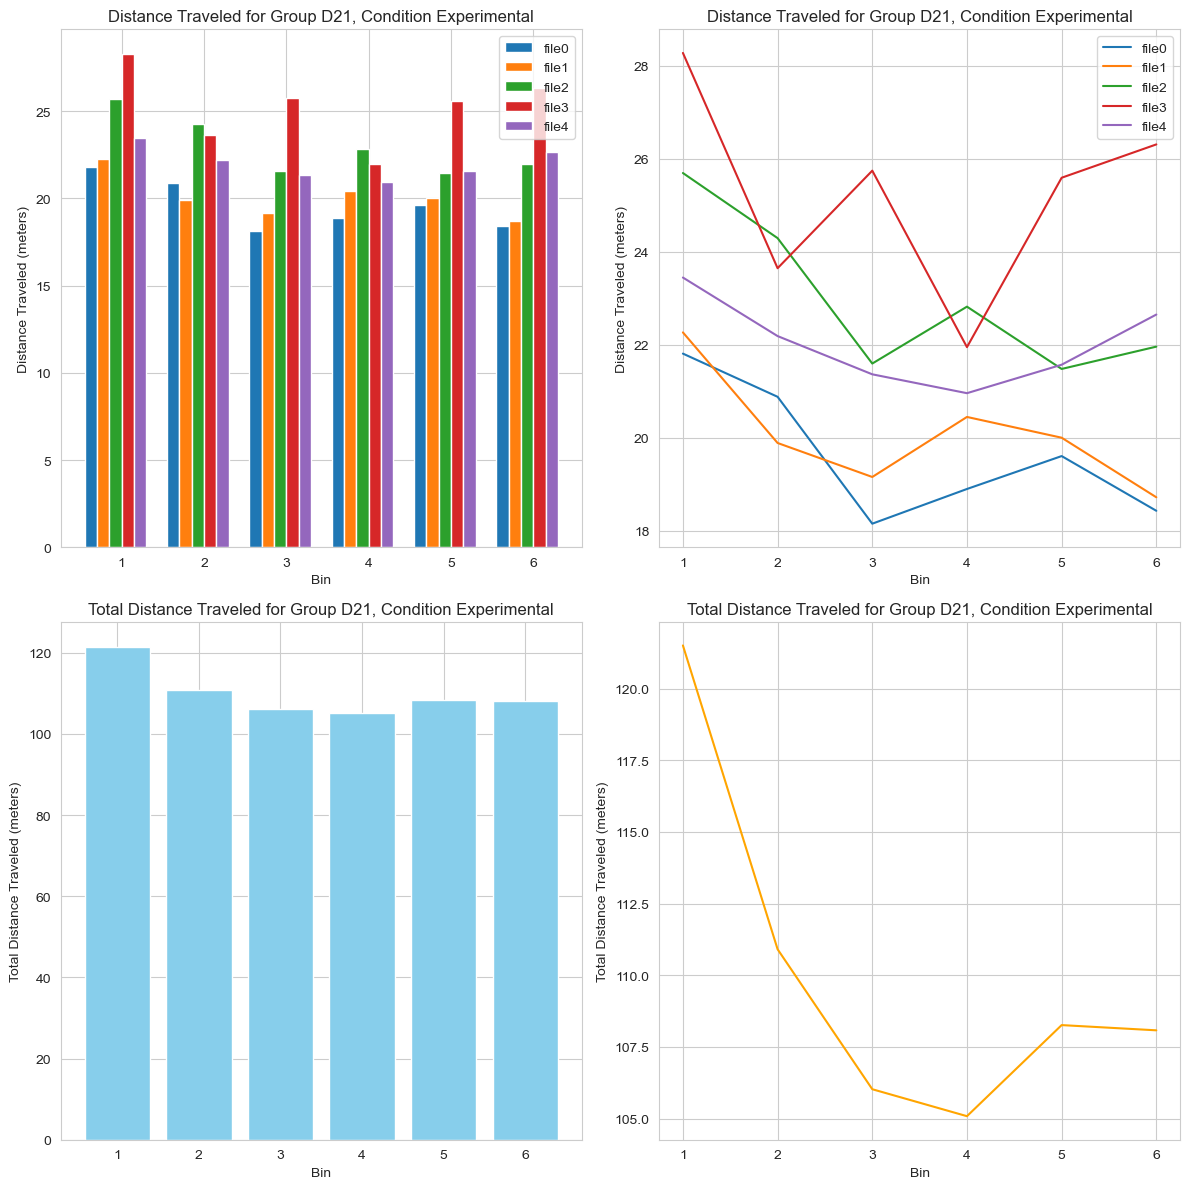

In [32]:
import csv
import numpy as np
import matplotlib.pyplot as plt

project = 'raquel'
selected_group = 'D21'
selected_condition = 'Experimental'

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

# Conversion factor from pixels to units
pixels_to_units = 0.000330708  # meters = 0.000330708, cm = 0.0330828
unit = 'meters'

# Number of frames representing a XX-minute interval
    # 1-minute bin = 3600
    # 2-minute bin = 7200
    # 3-minute bin = 10800
    # 5-minute bin = 18000
bin_interval = '5-minute'
frames_per_bin = 18000

# Assuming poses is a dictionary containing pose data for different groups and conditions
# Example structure: poses[group][condition][file][frame][bodypart_idx]
poses_selected = poses[selected_group][selected_condition]

# CSV SAVE
output_filename = f'../processed_dataset/behavior_distance-traveled/behavior_distance-binned_{unit}_{selected_group}_{selected_condition}_{project}.csv'

# Collect the file keys for all files
file_keys = list(poses_selected.keys())

# Determine the minimum number of frames among all files
min_frames = min(len(poses_selected[file_key]) for file_key in file_keys)

with open(output_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ['Bin']
    header.extend(file_keys)  # Add file keys as column headers
    writer.writerow(header)

    total_distance_bins = [[] for _ in range(len(file_keys))]  # List to store total distances for each file

    for frame in range(1, min_frames):
        bin_number = frame // frames_per_bin
        row_data = [bin_number]

        for file_key in file_keys:
            pose_data = poses_selected[file_key]
            if frame >= len(pose_data):
                continue  # Skip frames that exceed the length of the file
            distance_pixels = np.linalg.norm(pose_data[frame][bodypart_idx:bodypart_idx+2] - pose_data[frame-1][bodypart_idx:bodypart_idx+2])
            distance_units = distance_pixels * pixels_to_units
            row_data.append(distance_units)
            total_distance_bins[file_keys.index(file_key)].append(distance_units)

        if frame % frames_per_bin == 0:
            writer.writerow([bin_number] + [sum(total_distance_bins[i]) for i in range(len(file_keys))])
            total_distance_bins = [[] for _ in range(len(file_keys))]  # Reset total distances for next bin

# Read the CSV file to extract the distances traveled for each bin separately
bin_distances = [[] for _ in range(len(file_keys))]  # List to store distances for each file

with open(output_filename, mode='r', newline='') as file:
    reader = csv.DictReader(file)
    for row in reader:
        for i, file_key in enumerate(file_keys):
            distance_units = float(row[file_key])
            bin_distances[i].append(distance_units)

# Calculate the sum of distances traveled among all files for each bin
total_distances = [sum(distances) for distances in zip(*bin_distances)]

# Create a new figure
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot for individual files
bar_width = 0.15
num_bars = len(file_keys)
for i, file_key in enumerate(file_keys):
    x_positions = np.arange(1, len(bin_distances[i]) + 1) + (i - num_bars / 2) * bar_width
    axs[0, 0].bar(x_positions, bin_distances[i], width=bar_width, label=file_key)

# CHANGE AXIS LABELS FOR UNIT
axs[0, 0].set_xlabel('Bin')
axs[0, 0].set_ylabel(f'Distance Traveled ({unit})')
axs[0, 0].set_title(f'Distance Traveled for Group {selected_group}, Condition {selected_condition}')
axs[0, 0].set_xticks(np.arange(1, len(bin_distances[0]) + 1))
axs[0, 0].set_xticklabels(np.arange(1, len(bin_distances[0]) + 1))
axs[0, 0].legend()

# Plot for total distance traveled among all files
axs[1, 0].bar(np.arange(1, len(total_distances) + 1), total_distances, color='skyblue')
axs[1, 0].set_xlabel('Bin')
axs[1, 0].set_ylabel(f'Total Distance Traveled ({unit})')
axs[1, 0].set_title(f'Total Distance Traveled for Group {selected_group}, Condition {selected_condition}')
axs[1, 0].set_xticks(np.arange(1, len(total_distances) + 1))
axs[1, 0].set_xticklabels(np.arange(1, len(total_distances) + 1))

# Plot for individual files (line graph)
for i, file_key in enumerate(file_keys):
    axs[0, 1].plot(np.arange(1, len(bin_distances[i]) + 1), bin_distances[i], label=file_key)

# CHANGE AXIS LABELS FOR UNIT
axs[0, 1].set_xlabel('Bin')
axs[0, 1].set_ylabel(f'Distance Traveled ({unit})')
axs[0, 1].set_title(f'Distance Traveled for Group {selected_group}, Condition {selected_condition}')
axs[0, 1].set_xticks(np.arange(1, len(bin_distances[0]) + 1))
axs[0, 1].set_xticklabels(np.arange(1, len(bin_distances[0]) + 1))
axs[0, 1].legend()

# Plot for total distance traveled among all files (line graph)
axs[1, 1].plot(np.arange(1, len(total_distances) + 1), total_distances, color='orange')
axs[1, 1].set_xlabel('Bin')
axs[1, 1].set_ylabel(f'Total Distance Traveled ({unit})')
axs[1, 1].set_title(f'Total Distance Traveled for Group {selected_group}, Condition {selected_condition}')
axs[1, 1].set_xticks(np.arange(1, len(total_distances) + 1))
axs[1, 1].set_xticklabels(np.arange(1, len(total_distances) + 1))

plt.tight_layout()

# Save the figure as SVG
fig.savefig(f'../figures/behavior_distance-binned_{unit}_{selected_group}_{selected_condition}_{project}.svg', format='svg')

plt.show()

## HEATMAP Distance Traveled Figure!

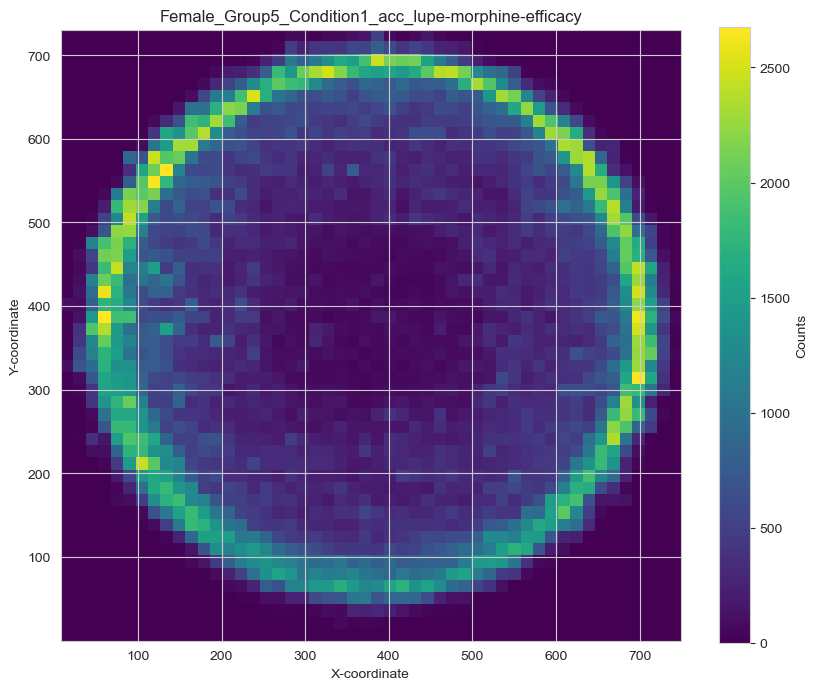

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

# Example pose dataset (x, y coordinates of tailbase) for selected_group_1 and selected_condition_1
project = 'acc_lupe-morphine-efficacy'
#selected_sex = 'Female'
selected_group = 'Group5'
selected_condition = 'Condition1'

# Assuming poses is a dictionary containing pose data for different groups and conditions
# Example structure: poses[group][condition][file][frame][bodypart_idx]
poses_selected = poses[selected_sex][selected_group][selected_condition]

# Create a list to store x and y coordinates
x_coords = []
y_coords = []

for file_key in poses_selected:
    pose_data = poses_selected[file_key]
    for frame in range(1, len(pose_data)):
        x_coords.append(pose_data[frame][bodypart_idx])
        y_coords.append(pose_data[frame][bodypart_idx + 1])

# Create a heatmap
heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 8))
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Counts')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title(f'{selected_sex}_{selected_group}_{selected_condition}_{project}')

# Save the figure as SVG
plt.savefig('heatmap.svg', format='svg')
plt.savefig(f'../figures/behavior_distance-heatmap_{selected_sex}_{selected_group}_{selected_condition}_{project}.svg', format='svg')
plt.show()

## Combined Data Analysis

#### COMBINED Group-Condition - Distance Traveled Stat

In [29]:
import csv
import numpy as np

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

project = 'acc_lupe-morphine-efficacy'
sexes = ['Male', 'Female']
selected_group = 'Group7'
selected_condition = 'Condition3B'

# Conversion factor from pixels to units
pixels_to_units = 0.0330828  # meters = 0.000330708, cm = 0.0330828
unit = 'cm'

# Initialize lists to store distances traveled for each sex
distances_traveled = []
cumulative_distances_traveled = []

for selected_sex in sexes:
    poses_selected = poses[selected_sex][selected_group][selected_condition]
    cumulative_distance_traveled = 0.0
    sex_distances_traveled = []
    
    for file_key in poses_selected:
        pose_data = poses_selected[file_key]
        total_distance_pixels = 0.0
        for frame in range(1, len(pose_data)):
            # Calculate Euclidean distance between consecutive frames in pixels
            distance_pixels = np.linalg.norm(pose_data[frame][bodypart_idx:bodypart_idx+2] - pose_data[frame-1][bodypart_idx:bodypart_idx+2])
            total_distance_pixels += distance_pixels
        # Convert total distance from pixels to units
        total_distance = total_distance_pixels * pixels_to_units
        # Append to list and update cumulative distance traveled
        sex_distances_traveled.append(total_distance)
        cumulative_distance_traveled += total_distance
    
    # Append the sum of distances to the list
    distances_traveled.append(sum(sex_distances_traveled))
    cumulative_distances_traveled.append(cumulative_distance_traveled)

# Convert lists to numpy arrays for easier computation
distances_traveled = np.array(distances_traveled)
cumulative_distances_traveled = np.array(cumulative_distances_traveled)

# Calculate combined statistics
average_distance = np.mean(distances_traveled)
standard_deviation = np.std(distances_traveled)
sem = standard_deviation / np.sqrt(len(distances_traveled.flatten()))
cumulative_distance_traveled = np.sum(cumulative_distances_traveled)

# Print results
print(f"Average distance traveled for sexes 'Male' and 'Female' and group '{selected_group}' and condition '{selected_condition}': {average_distance:.2f} {unit}")
print(f"Standard deviation: {standard_deviation:.2f} {unit}")
print(f"Standard error of the mean (SEM): {sem:.2f} {unit}")
print(f"Cumulative distance traveled: {cumulative_distance_traveled:.2f} {unit}")

# Save statistics to CSV
output_filename = f'../processed_dataset/behavior_distance-traveled/behavior_distance_stats-{unit}_MaleFemale_{selected_group}_{selected_condition}_{project}.csv'
with open(output_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Statistic', 'Value'])
    writer.writerow(['Average distance traveled', f'{average_distance:.2f} {unit}'])
    writer.writerow(['Standard deviation', f'{standard_deviation:.2f} {unit}'])
    writer.writerow(['Standard error of the mean (SEM)', f'{sem:.2f} {unit}'])
    writer.writerow(['Cumulative distance traveled', f'{cumulative_distance_traveled:.2f} {unit}'])


Average distance traveled for sexes 'Male' and 'Female' and group 'Group7' and condition 'Condition3B': 59523.16 cm
Standard deviation: 1413.98 cm
Standard error of the mean (SEM): 999.83 cm
Cumulative distance traveled: 119046.32 cm


####

#### COMBINED HEATMAP Distance Traveled Figure!

In [8]:
poses['Male']['Group5']['Condition2']

{'file0': array([[440.50571015, 716.54368156, 447.8224113 , ..., 558.78158092,
         587.49429512, 524.58428374],
        [437.95687485, 713.34399724, 443.31146502, ..., 559.52989054,
         588.86118746, 524.52882111],
        [434.70131922, 714.95285368, 439.88443285, ..., 561.79041576,
         586.8296957 , 525.21919793],
        ...,
        [221.74210238, 178.56106532, 226.67672253, ..., 194.4599185 ,
         199.32000163, 172.80242115],
        [217.78631163, 183.38823435, 209.3632524 , ..., 199.54446006,
         194.20249701, 181.42908263],
        [207.2081416 , 191.56904498, 199.32764086, ..., 207.93376468,
         184.1600281 , 183.3586387 ]]),
 'file1': array([[679.76759481, 405.14724208, 680.02633452, ..., 559.73840022,
         522.13190222, 577.80761218],
        [681.95769656, 399.62306178, 681.69465363, ..., 557.1928339 ,
         525.97390008, 575.57788098],
        [679.97151071, 391.43422854, 679.0417488 , ..., 549.13775682,
         531.60098267, 570.532131

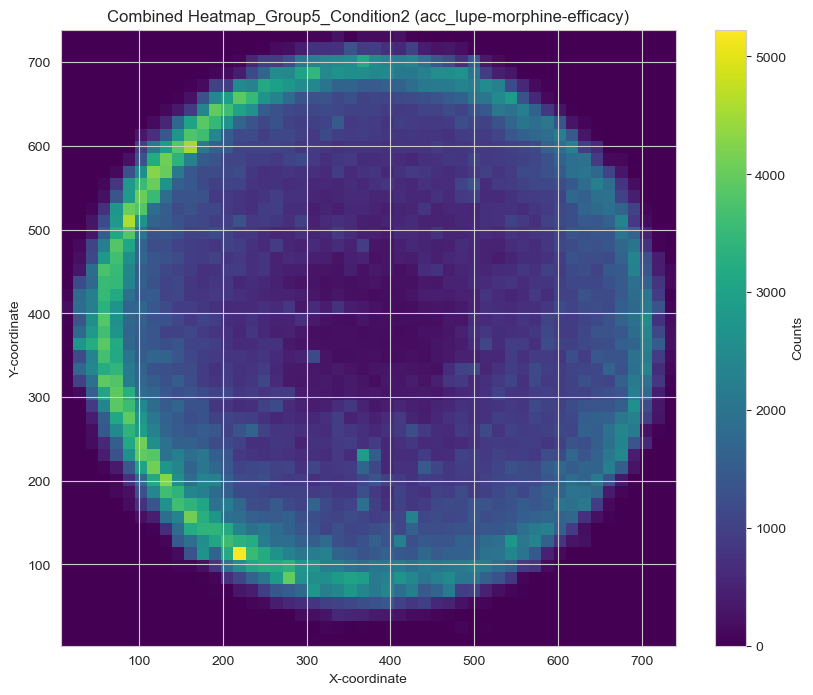

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

# Example pose dataset for males and females
project = 'acc_lupe-morphine-efficacy'
sexes = ['Male', 'Female']
groups = ['Group5']
conditions = ['Condition2']

# Create lists to store x and y coordinates
x_coords = []
y_coords = []

for selected_sex in sexes:
    for selected_group in groups:
        for selected_condition in conditions:
            poses_selected = poses[selected_sex][selected_group][selected_condition]
            for file_key in poses_selected:
                pose_data = poses_selected[file_key]
                for frame in range(1, len(pose_data)):
                    x_coords.append(pose_data[frame][bodypart_idx])
                    y_coords.append(pose_data[frame][bodypart_idx + 1])

# Create a heatmap
heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 8))
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Counts')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title(f'Combined Heatmap_{selected_group}_{selected_condition} ({project})')

# Save the figure as SVG
plt.savefig('heatmap.svg', format='svg')
plt.savefig(f'../figures/behavior_distance-heatmap_combined_{selected_group}_{selected_condition}_{project}.svg', format='svg')
plt.show()


#### HEATMAP - Combined SidebySide

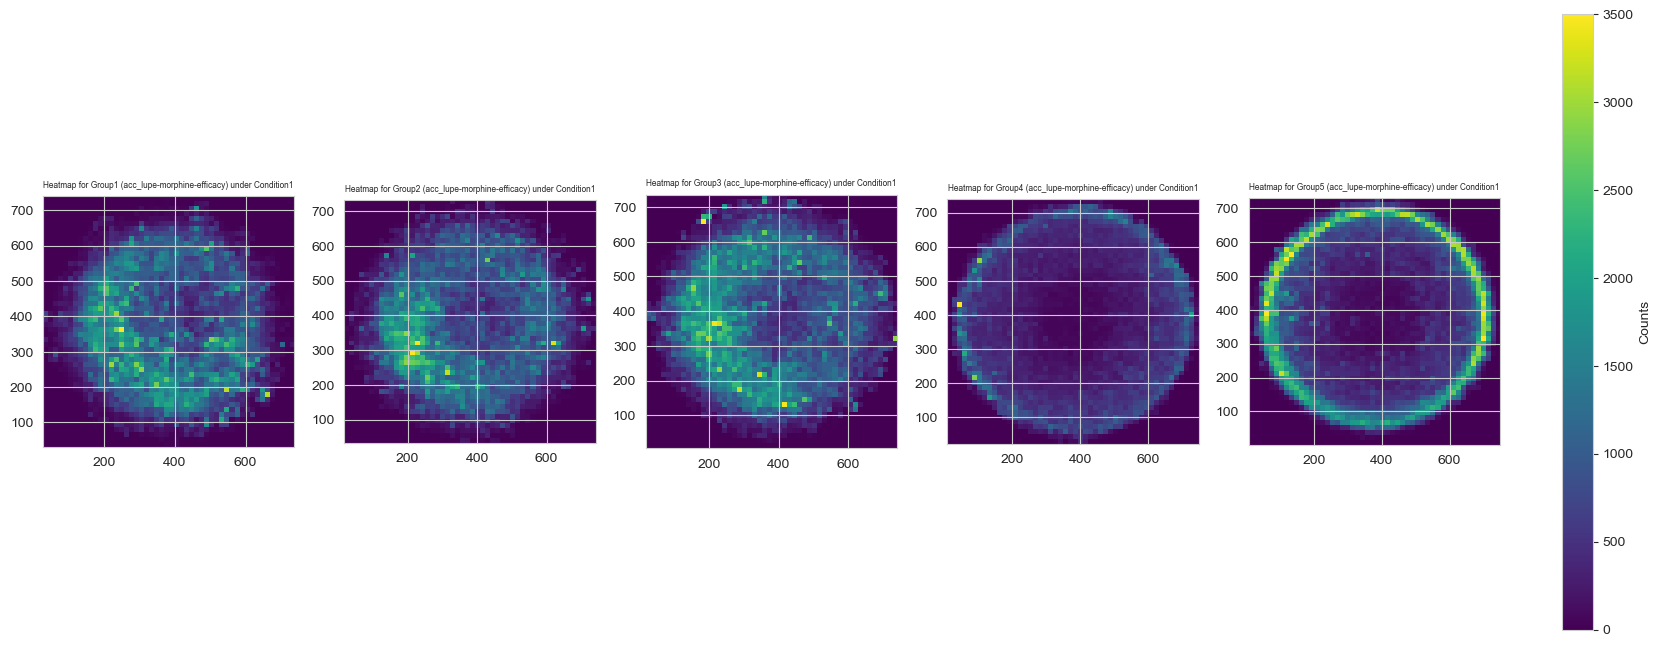

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

# Example pose dataset for males and females
project = 'acc_lupe-morphine-efficacy'
sexes = ['Male', 'Female']
groups = ['Group1', 'Group2', 'Group3', 'Group4', 'Group5']
conditions = ['Condition1']

fig, axs = plt.subplots(1, 5, figsize=(20, 8))

for i, selected_group in enumerate(groups):
    for selected_sex in sexes:
        if selected_group in ['Group1', 'Group2', 'Group3', 'Group4', 'Group5']:
            for selected_condition in conditions:
                # Create lists to store x and y coordinates
                x_coords = []
                y_coords = []
                poses_selected = poses[selected_sex][selected_group][selected_condition]
                for file_key in poses_selected:
                    pose_data = poses_selected[file_key]
                    for frame in range(1, len(pose_data)):
                        x_coords.append(pose_data[frame][bodypart_idx])
                        y_coords.append(pose_data[frame][bodypart_idx + 1])

                # Create a heatmap
                heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=50)
                extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

                axs[i].imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', interpolation='nearest')
                axs[i].set_title(f'Heatmap for {selected_group} ({project}) under {selected_condition}', fontsize=6)

# Add a colorbar
cbar = fig.colorbar(axs[0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Counts')

# Save the figure as SVG
plt.savefig(f'../figures/behavior_distance-heatmaps_combined_{selected_condition}_{project}.svg', format='svg')
plt.show()


#### HEATMAP - Nocifensive Behavior Comparison - Side by Side w/ SAME RANGE!

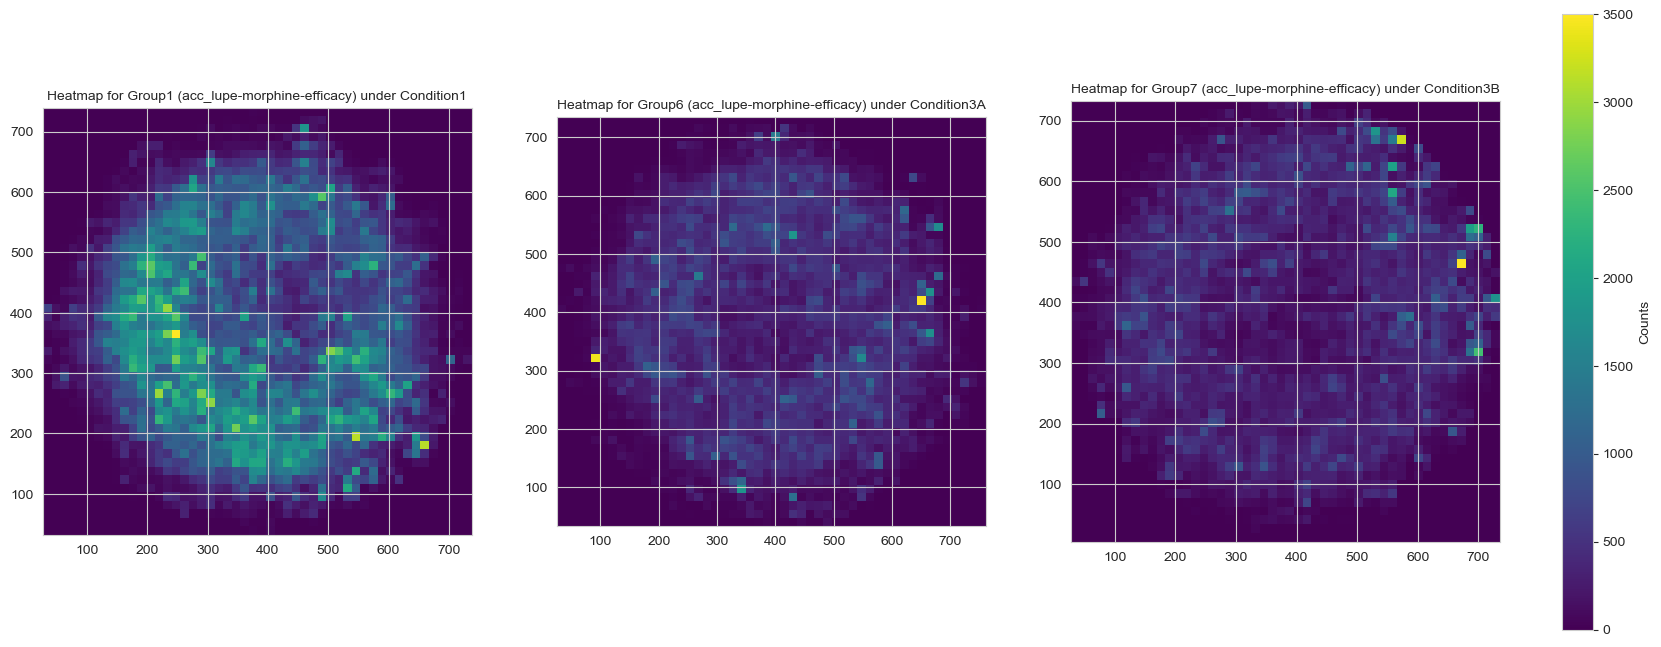

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

# Example pose dataset for males and females
project = 'acc_lupe-morphine-efficacy'
sexes = ['Male', 'Female']
groups = ['Group1', 'Group6', 'Group7']
conditions = ['Condition1', 'Condition3A', 'Condition3B']

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Initialize extent values to None
extent_values = None

for i, (selected_group, selected_condition) in enumerate(zip(groups, conditions)):
    for selected_sex in sexes:
        if selected_group in ['Group1', 'Group6', 'Group7']:
            # Create lists to store x and y coordinates
            x_coords = []
            y_coords = []
            poses_selected = poses[selected_sex][selected_group][selected_condition]
            for file_key in poses_selected:
                pose_data = poses_selected[file_key]
                for frame in range(1, len(pose_data)):
                    x_coords.append(pose_data[frame][bodypart_idx])
                    y_coords.append(pose_data[frame][bodypart_idx + 1])

            # Create a heatmap
            heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=50)
            extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

            if extent_values is None:
                extent_values = extent
            else:
                # Update extent values to ensure all figures are scaled the same size
                extent_values = [
                    min(extent_values[0], extent[0]),
                    max(extent_values[1], extent[1]),
                    min(extent_values[2], extent[2]),
                    max(extent_values[3], extent[3])
                ]

            axs[i].imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', interpolation='nearest')
            axs[i].set_title(f'Heatmap for {selected_group} ({project}) under {selected_condition}', fontsize=10)
            
            # Set number of ticks on each axis
            axs[i].locator_params(axis='x', nbins=10)
            axs[i].locator_params(axis='y', nbins=10)

            # Set the extent of the image to match the axes' limits
            axs[i].set_xlim(extent[0], extent[1])
            axs[i].set_ylim(extent[2], extent[3])

# Add a colorbar
cbar = fig.colorbar(axs[0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Counts')

# Save the figure as SVG
plt.savefig(f'../figures/behavior_distance-heatmaps_combined_{project}.svg', format='svg')
plt.show()


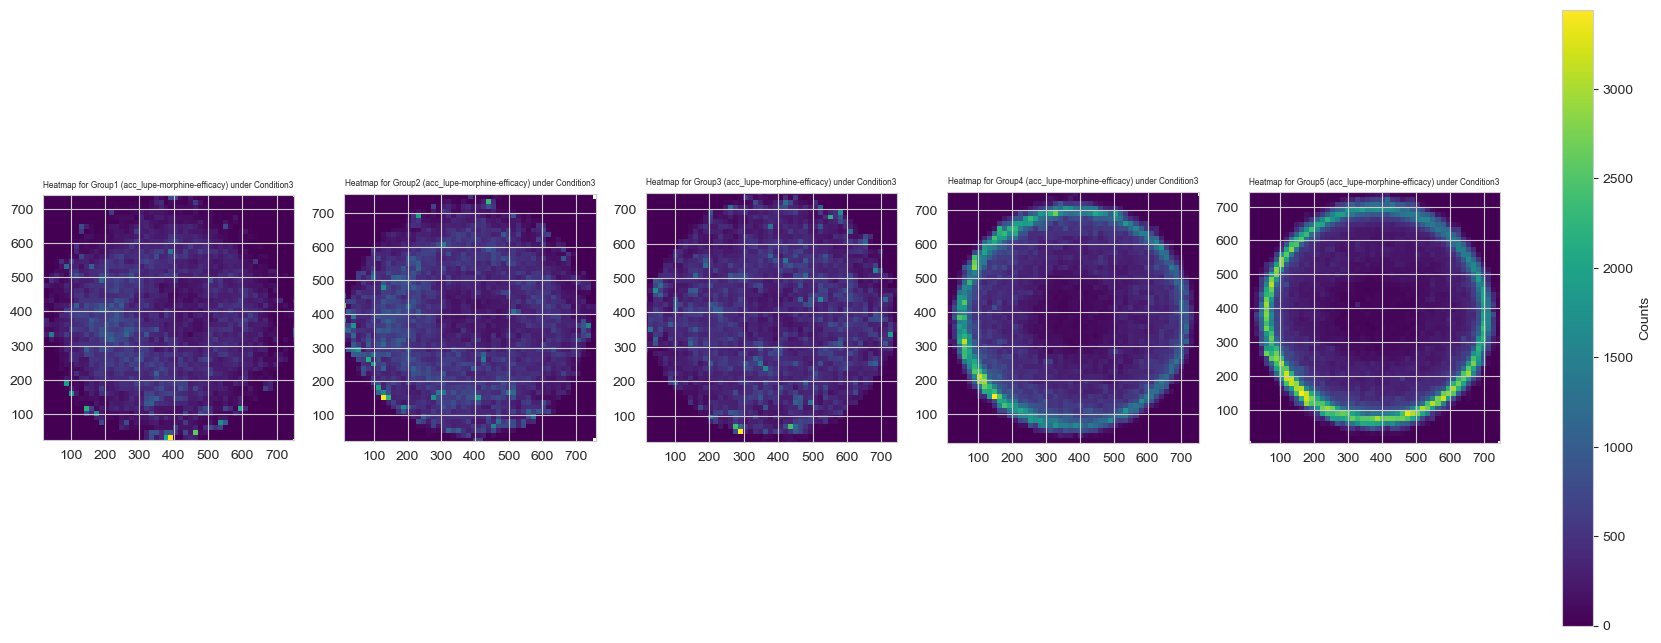

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define the index of the body part representing the tailbase
bodypart_idx = 38  # Assuming tailbase x-coordinate is at index 38 and y-coordinate is at index 39

# Example pose dataset for males and females
project = 'acc_lupe-morphine-efficacy'
sexes = ['Male', 'Female']
groups = ['Group1', 'Group2', 'Group3', 'Group4', 'Group5']
conditions = ['Condition3']

fig, axs = plt.subplots(1, 5, figsize=(20, 8))

for i, selected_group in enumerate(groups):
    for selected_sex in sexes:
        if selected_group in ['Group1', 'Group2', 'Group3', 'Group4', 'Group5']:
            for selected_condition in conditions:
                # Create lists to store x and y coordinates
                x_coords = []
                y_coords = []
                poses_selected = poses[selected_sex][selected_group][selected_condition]
                for file_key in poses_selected:
                    pose_data = poses_selected[file_key]
                    for frame in range(1, len(pose_data)):
                        x_coords.append(pose_data[frame][bodypart_idx])
                        y_coords.append(pose_data[frame][bodypart_idx + 1])

                # Create a heatmap
                heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=50)
                extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

                im = axs[i].imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', interpolation='nearest')
                axs[i].set_title(f'Heatmap for {selected_group} ({project}) under {selected_condition}', fontsize=6)

                # Set number of ticks on each axis
                axs[i].locator_params(axis='x', nbins=10)
                axs[i].locator_params(axis='y', nbins=10)

# Add a colorbar
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Counts')

# Save the figure as SVG
plt.savefig(f'../figures/behavior_distance-heatmaps_combined_{selected_condition}_{project}.svg', format='svg')
plt.show()
